## 1. 라이브러리 호출

In [1]:
import os, re
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## 2. 트랜스포머 모델 생성

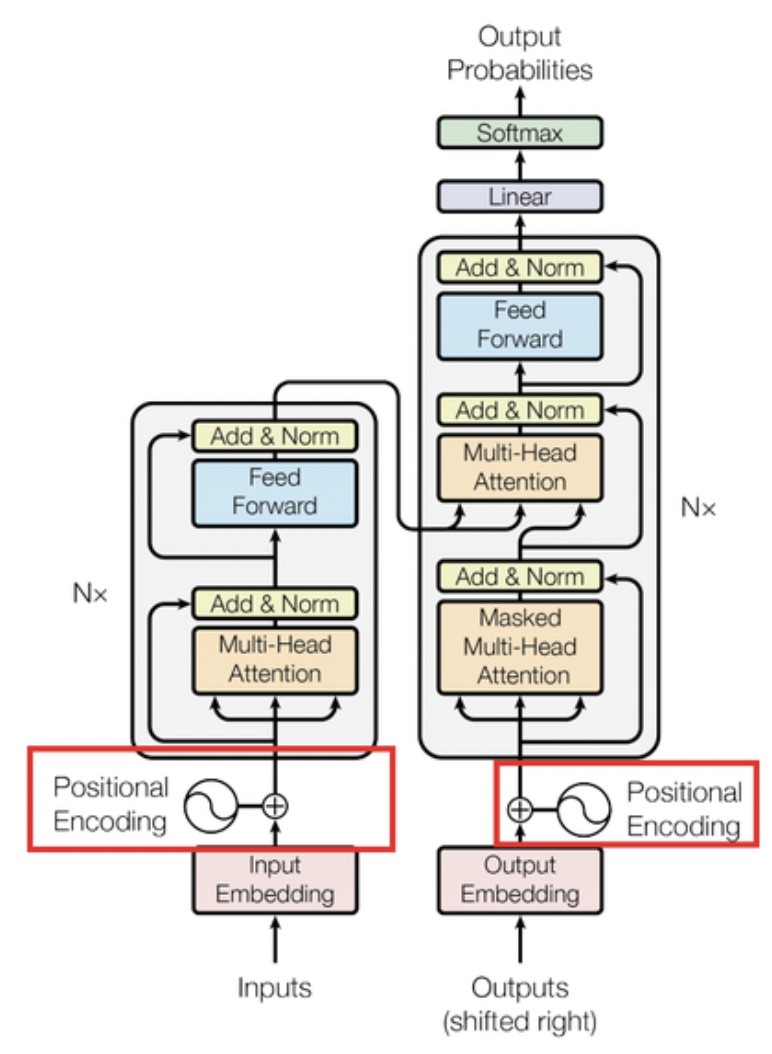

### 1 ) Positional Encoding

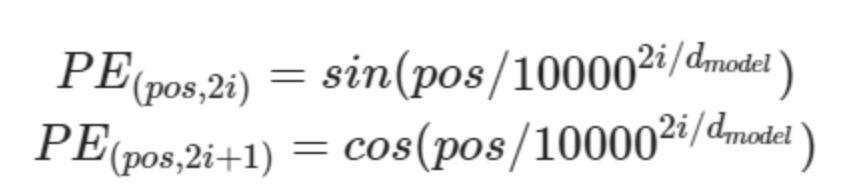

In [2]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        
        # Positional Encoding을 적용시킨 P_E matrix
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, position, i, d_model):
        '''
        
        sin이나 cos내에 들어갈 angle을 구하는 함수
        
        '''
        # cos, sin이 적용될 각도들을 구한다.
        angles = 1 / tf.pow(10000, (2 * ( i // 2) / tf.cast(d_model, tf.float32)))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        '''
        
        positional encoding matrix를 반환하는 함수
        
        '''
        
        # get_angles를 이용하여 각도 벡터들을 구한다. (문장 최대길이, 임베딩 차원)
        angle_rads = self.get_angles(
                     position = tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                     i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                     d_model = d_model
                     )
        # sin과 cos을 적용시킨 값들을 구한다. ( 문장 최대길이, 임베딩 차원 // 2)
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # sin과 cos을 stack한다. (2, 문장 최대길이, 임베딩 차원 // 2)
        pos_encoding = tf.stack([sines, cosines], axis=0)
        # 차원변경을 진행한다. (문장 최대길이, 임베딩 차원 // 2, 2)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        # reshape을 진행한다. (문장 최대길이, 임베딩 차원)
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])  
        # 텐서 차원을 맞추기 위해 차원을 늘린다, (1, 문장 최대길이, 임베딩 차원)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

#### ( 1 ) get_angles

- angles

In [3]:
position = 50
d_model = 512
angle_list = list(map(lambda i : 1 / tf.pow(10000, (2 * ( i // 2) / tf.cast(d_model, tf.float32))), range(512)))

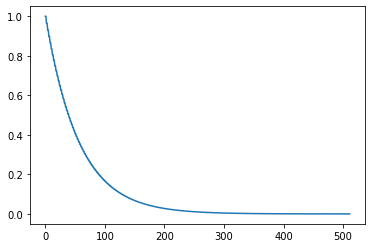

In [4]:
plt.plot(angle_list)

- position + angles

In [5]:
tmp = tf.range(position, dtype=tf.float32)[:, tf.newaxis] * tf.convert_to_tensor(angle_list, dtype=tf.float32)

In [6]:
tmp.shape

TensorShape([50, 512])

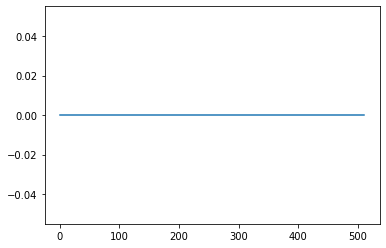

In [7]:
plt.plot(tmp.numpy()[0])

#### 보이다시피, position이 클수록 ( 문장중 최근에 나올수록 ) 값이 큰 것을 알 수 있다.

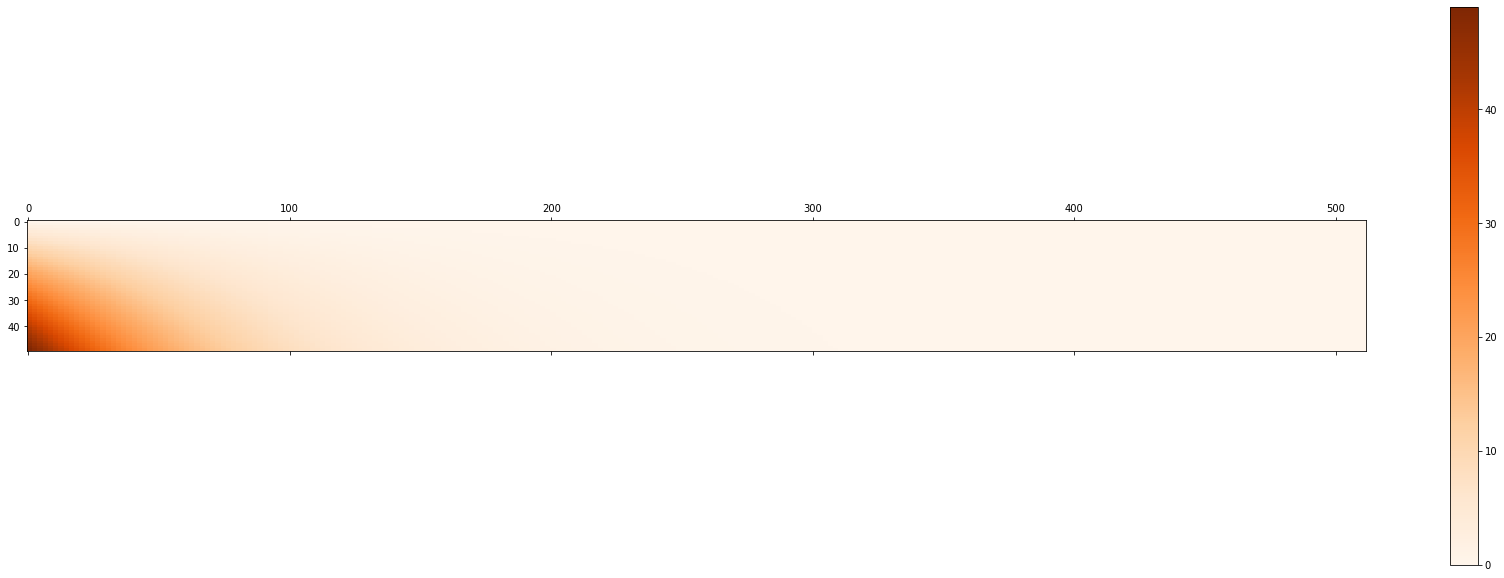

In [8]:
plt.figure(figsize=(30, 10))
plt.matshow(tmp, cmap='Oranges', fignum=1)
plt.colorbar()
plt.show()

In [9]:
sines = tf.math.sin(tmp[:, 0::2])
cosines = tf.math.cos(tmp[:, 1::2])

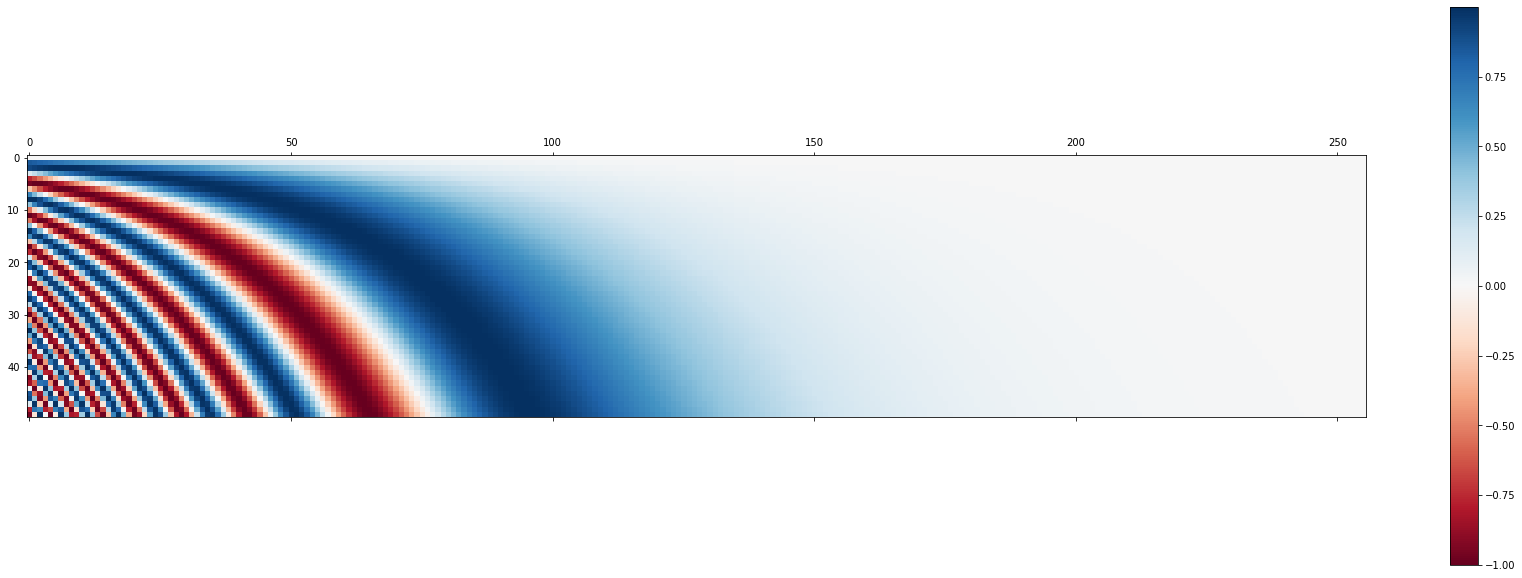

In [10]:
plt.figure(figsize=(30, 10))
plt.matshow(sines[:,:], cmap='RdBu', fignum=1)
plt.colorbar()
plt.show()

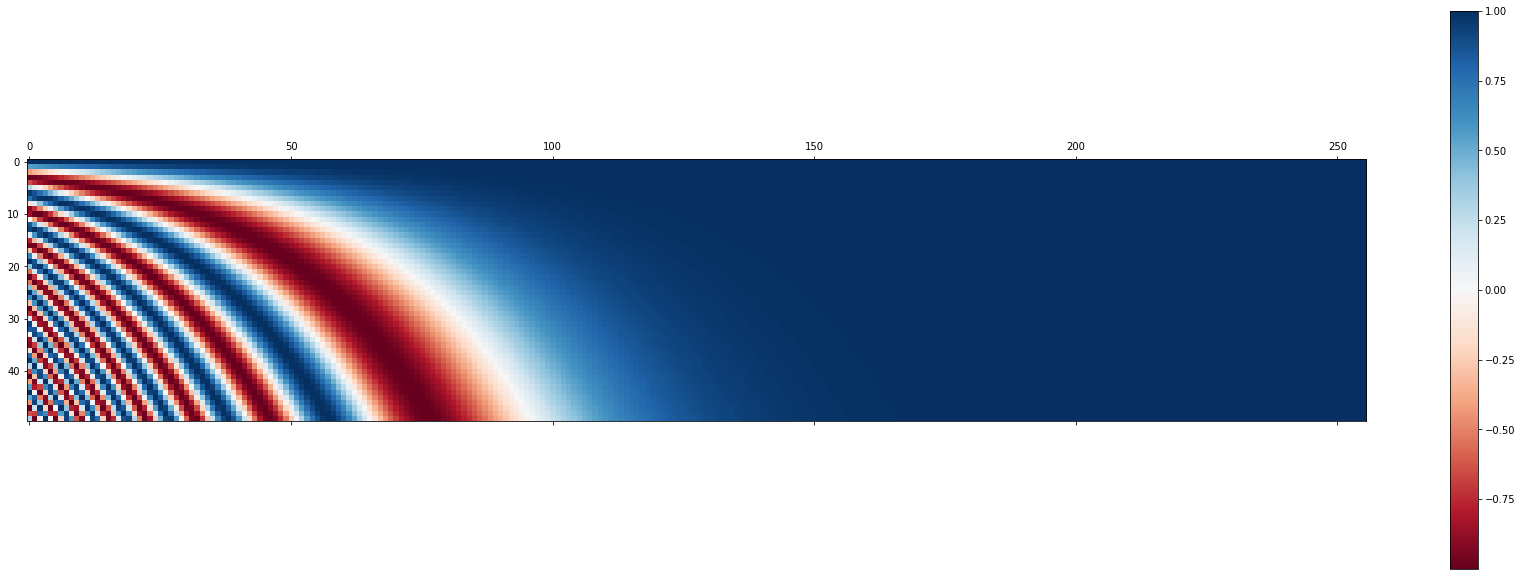

In [11]:
plt.figure(figsize=(30, 10))
plt.matshow(cosines[:,:], cmap='RdBu', fignum=1)
plt.colorbar()
plt.show()

In [12]:
pos_encoding = tf.stack([sines, cosines], axis=0)
pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
pos_encoding = tf.reshape(pos_encoding, [position, d_model])        
pos_encoding = pos_encoding[tf.newaxis, ...]

In [13]:
sines[0,:]

<tf.Tensor: shape=(256,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [14]:
cosines[0,:]

<tf.Tensor: shape=(256,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

#### 결과를 보면, 각 포지션 별로 값이 다르게 표현된 것을 볼 수 있다. 즉, 위치 별로 값을 달리하여 위치 정보를 삽입할 수 있다.

#### 이 그림은 실제 input이 더해진 행렬을 시각화 한 것이 아니라, Positional Embedding 행렬만 시각화 한 것임을 유의하자.

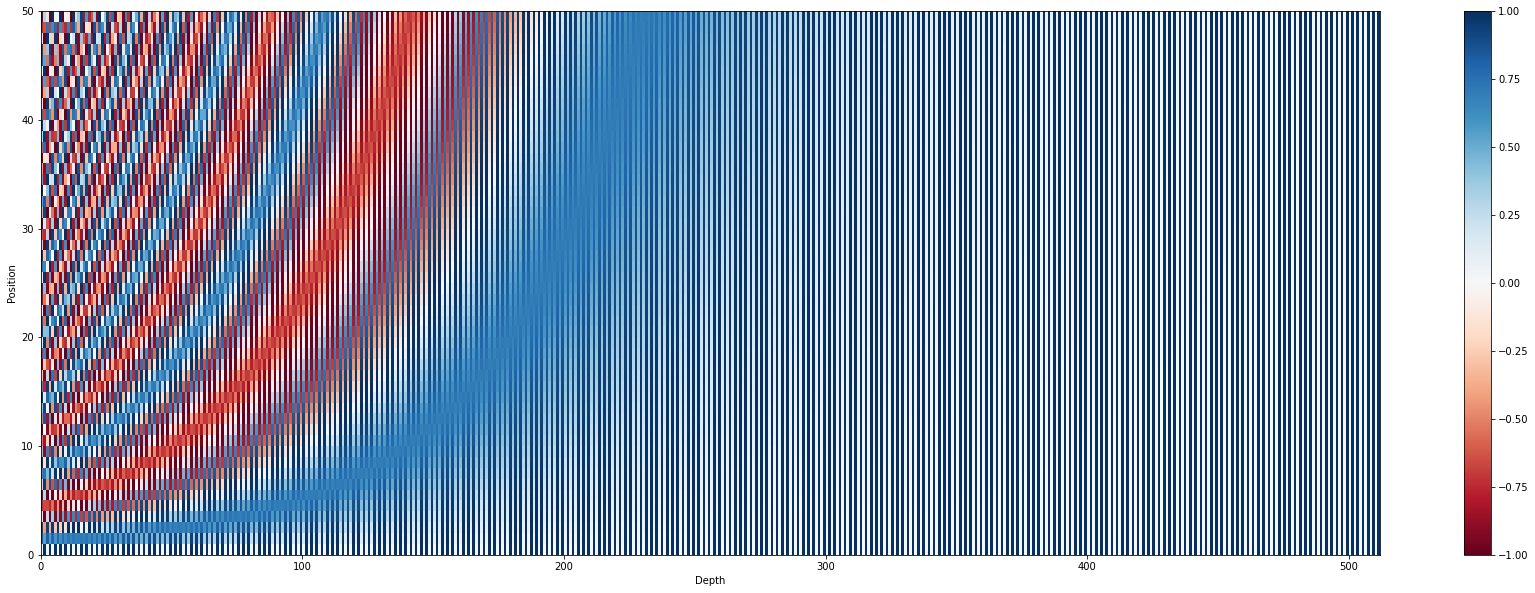

In [15]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.figure(figsize=(30, 10))
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [16]:
sample_pos_encoding.pos_encoding.numpy()[0][0]

array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1.

### 2 ) Multi-head Attention

### Attention이란?

#### Process ) Query, Key, Value를 입력으로 하며, Attention value를 출력한다.
#### Attention 과정은 단어 간 유사도를 구하는 것을 의미한다. 이 유사도를 Attention Value로 표현하는 것이다.

- 인코더 셀프 어텐션 : 인코더의 입력으로 들어간 문장 내 단어 간의 유사도를 구한다.
- 디코더 셀프 어텐션 : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
- 인코더-디코더 어텐션 : 디코더가 잘! 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.

#### Attention Value

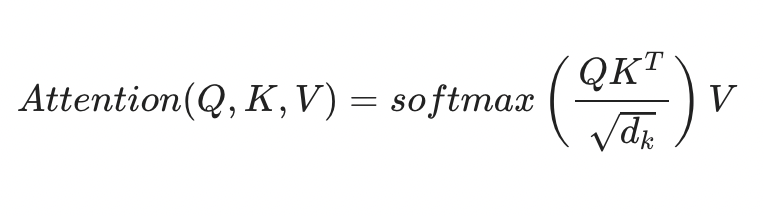

In [17]:
def scaled_dot_product_attention(query, key, value, mask):
    '''
    
    Attention Value를 구하는 함수
    
    parameter : Query, Key, Value, Mask
    
    
    '''
    # 1. Query값과 Key값의 곱인 QK^T 구한다.
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # 2. 임베딩 차원의 제곱근 값을 구하고, 이를 QK^T에 나누어준다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # 3. 마스크가 존재하면 마스크에 -10^9을 곱한 후, 더해준다. 
    if mask is not None:
        logits += (mask * -1e9)
    # 4. 소프트맥스를 적용시켜 값들의 범위를 0에서 1사이로 한정짓는다.
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # 5. 이 값에 Value를 곱하여 Attention Value를 얻는다.
    output = tf.matmul(attention_weights, value)
    
    return output

#### Mutli_Head_Attention

- 앙상블 효과가 있다고 한다.

In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name='multi_head_attention'):
        '''
        
        Multi Head Attention 함수
        
        '''
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        # d_model은 self.num_heads에 의해서 반드시 나누어 떨어져야한다.
        assert d_model % self.num_heads == 0 
        
        # self.depth = 임베딩 벡터 차원 / 어텐션 개수
        self.depth = d_model // self.num_heads 
        
        # Query : (배치 사이즈, 임베딩 차원)
        self.query_dense = tf.keras.layers.Dense(units=d_model) 
        # Key : (배치 사이즈, 임베딩 차원)
        self.key_dense = tf.keras.layers.Dense(units=d_model) 
        # Value : (배치 사이즈, 임베딩 차원)
        self.value_dense = tf.keras.layers.Dense(units=d_model) 
        # ???
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        # (배치 사이즈, 문장 최대길이, 임베딩 차원) -> (배치 사이즈, -1, 어텐션 개수, (임베딩 차원 / 어텐션 개수))
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        # (배치 사이즈, -1, 어텐션 개수, (임베딩 차원 / 어텐션 개수)) -> (배치 사이즈, 어텐션 개수, -1, (임베딩 차원 / 어텐션 개수))
        return tf.transpose(inputs, perm=[0, 2, 1, 3]) 
    
    def call(self, inputs):
        
        # 1. Q, K, V, 그리고 Mask를 입력으로 받는다.
        # ( 배치사이즈, 문장 최대길이, 임베딩 차원 )
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask'] 
        batch_size = tf.shape(query)[0]
        
        # 2. Q, K, V를 각각의 dense layer에 입력으로 사용하여 출력을 얻는다. (차원 유지)
        # ( 배치사이즈, 문장 최대길이, 임베딩 차원 )
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # 3. 어텐션의 개수에 맞게 Q, K, V들을 쪼갠다. 
        # (배치 사이즈, -1, 임베딩 벡터 차원) -> (배치 사이즈, 어텐션 개수, 문장 최대길이, (임베딩 차원 / 어텐션 개수))
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # 4. Attention Value를 계산하고, 다시 차원을 변경한다.
        # (배치 사이즈, 어텐션 개수, 문장 최대길이, (임베딩 차원 / 어텐션 개수)) -> (배치사이즈, 문장 최대길이, 어텐션 개수, (임베딩 차원 / 어텐션 개수))
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # 5. 분할시켰던 Attention Value들을 하나로 다시 합친다.
        # (배치사이즈, 문장 최대길이, 어텐션 개수, (임베딩 차원 / 어텐션 개수)) -> (배치사이즈, 문장 최대길이, 임베딩 차원)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        # 6. 이를 다시한번 dense layer에 통과시킨다.
        # (배치사이즈, -1, 임베딩 차원) -> (배치사이즈, 문장 최대길이, 임베딩 차원)
        outputs = self.dense(concat_attention)
        
        return outputs

In [19]:
batch_size = 64
position = 50
d_model = 512

In [20]:
a = MultiHeadAttention(d_model, 8)

#### split_heads 함수 사용시 차원 확인
- (64, 50, 512) -> (64, 8, 50, 64)

In [21]:
splited = a.split_heads(tf.random.normal((batch_size, position, d_model), dtype=tf.float32), batch_size)

In [22]:
splited.shape

TensorShape([64, 8, 50, 64])

#### call 함수시 차원 확인


- 1. input : ( 배치사이즈, 문장 최대길이, 임베딩 차원 )
- 2. self.query_dense : ( 배치사이즈, 문장 최대길이, 임베딩 차원 )
- 3. self.split_heads : ( 배치사이즈, 어텐션 개수, 문장 최대길이, 임베딩 차원 / 어텐션 개수 )
- 4. scaled_dot_product_attention : (배치사이즈, 문장 최대길이, 어텐션 개수, 임베딩 차원 / 어텐션 개수 )
- 5. tf.reshape : (배치사이즈, 문장 최대길이, 어텐션 개수 * 임베딩 차원 / 어텐션 개수 )
- 6. tf.keras.layers.Dense : (배치사이즈, 문장 최대길이, 어텐션 개수 * 임베딩 차원 / 어텐션 개수 )

### 3 ) Masking

#### ( 1 ) 패딩 마스킹
<br>

- 숫자가 0인 위치를 체크하는 마스킹 기법

#### 숫자가 0이라면 마스크에 1이 붙는다.

In [23]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (배치사이즈, 1, 1, 문장 최대길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [24]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


#### ( 2 ) Look Ahead Masking
<br>

- 자신보다 다음에 나올 단어를 참고하지 않도록 마스킹하는 기법

In [25]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

#### 마스킹 할 부분의 값이 1이 된다.

In [26]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [27]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [28]:
print(create_look_ahead_mask(tf.constant([[0, 5, 0, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 1. 0. 1.]
   [1. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 4 ) Encoder

#### ( 1 ) encoder_layer
<br>

- 하나의 임베딩 레이어 생성

In [29]:
def encoder_layer(units, d_model, num_heads, dropout, name='encoder_layer'):
    
    # (배치사이즈, 문장 최대길이, 임베딩차원)
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    # (배치사이즈, 1, 1, 문장 최대길이)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # Multi_Head_Attention 선언
    # (배치사이즈, 문장 최대길이, 임베딩차원)
    attention = MultiHeadAttention(d_model, num_heads, name='attention')(
                {
                    'query' : inputs,
                    'key' : inputs,
                    'value' : inputs,
                    'mask' : padding_mask
                })

    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # (배치사이즈, 문장 최대길이, 임베딩차원)
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # (배치사이즈, 문장 최대길이, 임베딩차원)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### ( 2 ) encoder
<br>

- 최종 결과는 (배치사이즈, 문장 최대길이, 임베딩 차원)

In [30]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='encoder'):
    
    # ()
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate = dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = encoder_layer(
                units=units,
                d_model=d_model,
                num_heads=num_heads,
                dropout=dropout,
                name='encoder_layer_{}'.format(i),
                )([outputs, padding_mask])
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [31]:
encoder(1024, 3, 512, 256, 8, 0.1)([tf.random.normal((64, 50)), tf.random.normal((64, 1, 1, 50))]).shape

TensorShape([64, 50, 256])

In [32]:
encoder(1024, 3, 512, 256, 8, 0.1).summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    262144      inputs[0][0]                     
__________________________________________________________________________________________________
tf.math.multiply_1 (TFOpLambda) (None, None, 256)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
positional_encoding_2 (Position (None, None, 256)    0           tf.math.multiply_1[0][0]         
____________________________________________________________________________________________

## 5 ) decoder

#### ( 1 ) decoder layer

In [33]:
def decoder_layer(units, d_model, num_heads, dropout, name='decoder_layer'):
    
    # (배치사이즈, 문장 최대길이, 임베딩차원)
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None,d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # Multi_Head_Attention 선언
    # (배치사이즈, 문장 최대길이, 임베딩차원)
    attention1 = MultiHeadAttention(d_model, num_heads, name='attention_1')(
                {
                    'query' : inputs,
                    'key' : inputs,
                    'value' : inputs,
                    'mask' : look_ahead_mask
                })

    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention1)

    attention2 = MultiHeadAttention(d_model, num_heads, name='attention_2')(
                {
                    'query' : attention1,
                    'key' : enc_outputs,
                    'value' : enc_outputs,
                    'mask' : padding_mask
                })

    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + attention2)

    # (배치사이즈, 문장 최대길이, 임베딩차원)
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # (배치사이즈, 문장 최대길이, 임베딩차원)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [34]:
decoder_layer(512, 256, 8, 0.1)([tf.random.normal((64, 50, 256)), tf.random.normal((64, 50, 256)), tf.random.normal((64, 1, 50, 50)), tf.random.normal((64, 1, 1, 50))]).shape

TensorShape([64, 50, 256])

#### ( 2 ) decoder

In [35]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None,d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate = dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(
                units=units,
                d_model=d_model,
                num_heads=num_heads,
                dropout=dropout,
                name='decoder_layer_{}'.format(i),
                )([outputs, enc_outputs, look_ahead_mask, padding_mask])
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [36]:
decoder(1024, 3, 512, 256, 8, 0.1)([tf.random.normal((64, 50)), tf.random.normal((64, 50, 256)), tf.random.normal((64, 1, 50, 50)), tf.random.normal((64, 1, 1, 50))]).shape

TensorShape([64, 50, 256])

In [37]:
decoder(1024, 3, 512, 256, 8, 0.1).summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    262144      inputs[0][0]                     
__________________________________________________________________________________________________
tf.math.multiply_3 (TFOpLambda) (None, None, 256)    0           embedding_3[0][0]                
__________________________________________________________________________________________________
positional_encoding_4 (Position (None, None, 256)    0           tf.math.multiply_3[0][0]         
____________________________________________________________________________________________

# 

# 

# 

# 

## 6 ) 모델 학습시키기

### Step 1. 데이터 전처리하기

In [38]:
import pandas as pd

In [39]:
data = pd.read_csv('/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv')

In [40]:
data.shape

(11823, 3)

In [41]:
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [42]:
MAX_SAMPLES = 11823
print(MAX_SAMPLES)

11823


In [43]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (가-힣 ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence) #한글 전처리
    sentence = sentence.strip()
    return sentence

In [44]:
def load_conversations():
    inputs, outputs = [], []
  #with open(path_to_movie_conversations, 'r') as file:
    #lines = file.readlines()

    for i in range(len(data)):
      # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        inputs.append(preprocess_sentence(data['Q'][i])) #questions
        outputs.append(preprocess_sentence(data['A'][i])) #answers
       
        if len(inputs) >= MAX_SAMPLES:
            return inputs, outputs
        
    return inputs, outputs

In [46]:
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

(array([1.268e+03, 5.163e+03, 2.920e+03, 1.559e+03, 5.880e+02, 2.440e+02,
        6.000e+01, 1.200e+01, 7.000e+00, 2.000e+00]),
 array([ 1. ,  6.6, 12.2, 17.8, 23.4, 29. , 34.6, 40.2, 45.8, 51.4, 57. ]),
 <BarContainer object of 10 artists>)

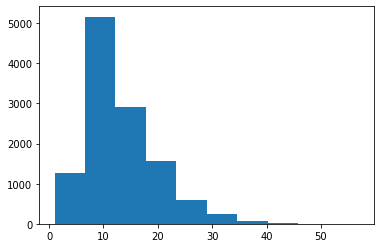

In [48]:
plt.hist((list(map(lambda x : x.__len__(), questions))))

(array([8.720e+02, 6.340e+03, 3.502e+03, 7.370e+02, 2.630e+02, 6.800e+01,
        2.500e+01, 1.100e+01, 2.000e+00, 3.000e+00]),
 array([ 1. ,  8.7, 16.4, 24.1, 31.8, 39.5, 47.2, 54.9, 62.6, 70.3, 78. ]),
 <BarContainer object of 10 artists>)

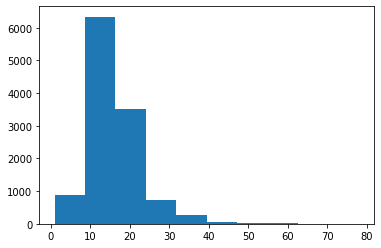

In [49]:
plt.hist((list(map(lambda x : x.__len__(), answers))))

In [50]:
max(list(map(lambda x : x.__len__(), questions)))

57

#### 90 %의 데이터는 문장 길이가 24이다.

In [51]:
np.quantile(list(map(lambda x : x.__len__(), questions)), 0.9)

22.0

In [52]:
np.quantile(list(map(lambda x : x.__len__(), answers)), 0.9)

24.0

In [53]:
MAX_LENGTH = 24

In [54]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[60]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 감정컨트롤을 못하겠어
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


In [55]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [56]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [57]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8127]
END_TOKEN의 번호 : [8128]


In [58]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8129


In [59]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5742, 612, 2481, 4148]
정수 인코딩 후의 21번째 답변 샘플: [2352, 7481, 7, 6245, 97, 1]


In [61]:
tokenizer.encode(data['A'][21])

[2352, 7481, 7, 6245, 97, 7917]

In [62]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [63]:
import tensorflow as tf

In [64]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8129
필터링 후의 질문 샘플 개수: 11815
필터링 후의 답변 샘플 개수: 11815


In [65]:
BATCH_SIZE = 64
BUFFER_SIZE = len(questions)

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [66]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [67]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3135232     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [68]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [69]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

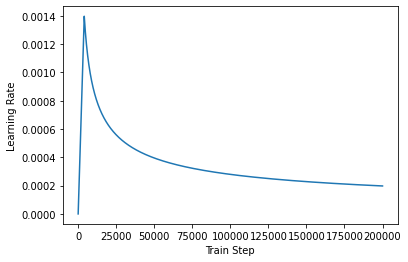

In [70]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [71]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [72]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 13s 42ms/step - loss: 2.4594 - accuracy: 0.0429
Epoch 2/50
185/185 [==============================] - 8s 42ms/step - loss: 2.0188 - accuracy: 0.0811
Epoch 3/50
185/185 [==============================] - 8s 43ms/step - loss: 1.7240 - accuracy: 0.0850
Epoch 4/50
185/185 [==============================] - 8s 42ms/step - loss: 1.6006 - accuracy: 0.0897
Epoch 5/50
185/185 [==============================] - 8s 42ms/step - loss: 1.5158 - accuracy: 0.0947
Epoch 6/50
185/185 [==============================] - 8s 43ms/step - loss: 1.4348 - accuracy: 0.0993
Epoch 7/50
185/185 [==============================] - 8s 43ms/step - loss: 1.3447 - accuracy: 0.1056
Epoch 8/50
185/185 [==============================] - 8s 43ms/step - loss: 1.2450 - accuracy: 0.1144
Epoch 9/50
185/185 [==============================] - 8s 42ms/step - loss: 1.1364 - accuracy: 0.1254
Epoch 10/50
185/185 [==============================] - 8s 43ms/step - loss: 1.0229 - accur

In [73]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [74]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [76]:
data.tail()

,Q,A,label
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2


In [77]:
sentence_generation('오늘 날씨는 어때?')

입력 : 오늘 날씨는 어때?
출력 : 하늘 보고 한 번 웃어봐요 . 기분이 바뀔 거예요 .


'하늘 보고 한 번 웃어봐요 . 기분이 바뀔 거예요 .'

In [78]:
sentence_generation('힘들다.')

입력 : 힘들다.
출력 : 힘내지 않아도 괜찮아요 .


'힘내지 않아도 괜찮아요 .'

In [79]:
sentence_generation('너는 이름이 뭐야?')

입력 : 너는 이름이 뭐야?
출력 : 위로봇이요 .


'위로봇이요 .'

In [80]:
sentence_generation('저녁 뭐 먹을지 고민돼.')

입력 : 저녁 뭐 먹을지 고민돼.
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [81]:
sentence_generation('머리가 복잡해.')

입력 : 머리가 복잡해.
출력 : 너무 자책하지 마세요 .


'너무 자책하지 마세요 .'

In [83]:
sentence_generation('여행 어디로 갈까?')

입력 : 여행 어디로 갈까?
출력 : 안 가본 가까운 곳이 좋겠죠 .


'안 가본 가까운 곳이 좋겠죠 .'

In [84]:
sentence_generation('여행 누구랑 갈까?')

입력 : 여행 누구랑 갈까?
출력 : 가랑비에 옷 젖는 듯한 사랑이었나봐요 .


'가랑비에 옷 젖는 듯한 사랑이었나봐요 .'

## 회고

#### Transformer의 분석을 통해 어떠한 정보를 어떤 방식으로 전달하는지 알 수 있었다.
#### Attention과 embedding의 개념에 대해 조금 더 살펴 볼 필요가 있을 것 같다.
#### Accuracy와 번역수준의 상관관계에 대해 살펴 볼 계획이다.